In [0]:
from sparkdl.xgboost import XgboostClassifier
from pyspark.ml.evaluation import Evaluator

from datetime import date
import pyspark.sql.functions as F
from pyspark.sql.functions import col, expr, explode, array, lit
from pyspark.sql.window import Window
import sys
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType
from graphframes import *
import numpy as np

In [0]:
# Load the joined airlines and weather observations in from Parquet
blob_container = "w261" # The name of your container created in https://portal.azure.com
storage_account = "bdougall" # The name of your Storage account created in https://portal.azure.com
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

In [0]:
def downsample(df):
    """A function that downsamples a dataframe's majority class to create a balanced dataset"""
    
    # Get the dataframes corresponding to the majority and minority classes
    major_obs = df.filter(col('OUTCOME') == 0)
    minor_obs = df.filter(col('OUTCOME') == 1)
    
    # Find the ratio of major class to minor class observations
    ratio = int(major_obs.count()/minor_obs.count())
    # Downsample the majority class
    reduced_majority = major_obs.sample(False, 1/ratio, seed=42)
    # Create a new dataset, with fewer majority class observations
    reduced_df = reduced_majority.unionAll(minor_obs)
    
    return reduced_df

In [0]:
def calculate_metrics(df):
    """A custom function to calculate recall, accuracy, and f1-score"""
    
    # Convert String to Integer Type
    df = df.withColumn('label',col('label').cast(IntegerType()))\
           .withColumn('prediction', col('prediction').cast(IntegerType()))
    
    cols = df.select('label', 'prediction').groupby('label', 'prediction').count()
    
    # Get the counts of each classification type
    tn = cols.filter((col('label') == 0) & (col('prediction') == 0)).collect()[0][2]
    tp = cols.filter((col('label') == 1) & (col('prediction') == 1)).collect()[0][2]
    fn = cols.filter((col('label') == 1) & (col('prediction') == 0)).collect()[0][2]
    fp = cols.filter((col('label') == 0) & (col('prediction') == 1)).collect()[0][2]
    
    # Calculate accuracy, recall, and f1-score
    if tn + tp + fn + fp == 0:
        accuracy, recall, f1, precision = 0, 0, 0, 0
    else:
        accuracy = float(tp + tn)/float(tp + fp + tn + fn)
    
    if (tp + fn) > 0:
        recall = (tp)/float(tp+fn)
    elif (tp + fn) == 0:
        recall = 0
    if (tp + fp + fn) > 0:
        f1_score = (tp)/float(tp + (0.5 * (fp + fn)))
    elif (tp + fp + fn) == 0:
        f1_score == 0
    if (tp + fp) > 0: 
        precision = float(tp)/float(tp + fp)
    elif (tp + fp) == 0:
        precision = 0
    
    return f1_score, recall, accuracy, precision

In [0]:
def tree_pipeline_v1(df,categoricals,numerics):
    """A version of the tree pipeline that accepts selected features, prepares the features in the dataframe for modeling, and creates a compressed feature space"""
    
    # Create the string indexer and ohe for categorical fields
    indexers_dt = StringIndexer(inputCols=categoricals, outputCols=[c+"_index" for c in categoricals], handleInvalid='keep')
    ohe_dt = OneHotEncoder(inputCols=[c+"_index" for c in categoricals], outputCols= [c+"_ohe" for c in categoricals])
    numFeatures_dt = VectorAssembler(inputCols=numerics, outputCol="numFeatures")
    featureCombiner_dt = VectorAssembler(inputCols=[c+"_ohe" for c in categoricals] + ["numFeatures"], outputCol="features")
    outcomeLabeler_dt = StringIndexer(inputCol="OUTCOME", outputCol="label")# 
    pipeline = Pipeline(stages = [indexers_dt, ohe_dt, numFeatures_dt, featureCombiner_dt, outcomeLabeler_dt])
    processed = pipeline.fit(df).transform(df)
    
    drop_index = [c + '_index' for c in categoricals]
    drop_ohe = [c + '_ohe' for c in categoricals]
    processed = processed.drop(*drop_index).drop(*drop_ohe).drop('numFeatures')
    return processed

#### Initial Baseline Models

In [0]:
baseline = spark.read.parquet(f"{blob_url}/added_v2")

baseline_raw = baseline.select('YEAR','CRS_ARR_TIME','HOUR','OUTCOME','rolling_perc_delayed','origin_dest_perc_24to2','origin_perc_24to2','last_flight_delayed','amount_last_delay','two_ago_delayed','arrival_time_2_next_flight','last_flight_late_arrival','two_ago_late_arrival')

baseline_raw = baseline_raw.filter((col('YEAR')>2015) & (col('YEAR')<2019))

#### Logistic Regression

In [0]:
baseline_numerics = ['CRS_ARR_TIME','HOUR','rolling_perc_delayed','origin_dest_perc_24to2','origin_perc_24to2','amount_last_delay','arrival_time_2_next_flight']
onehot = ['last_flight_delayed','two_ago_delayed','last_flight_late_arrival','two_ago_late_arrival']

def log_pipeline(df, baseline_numerics, categoricals):
    # Apply string indexing to categorical features
    indexers_lr = StringIndexer(inputCols=categoricals, outputCols=[c+"_index" for c in categoricals], handleInvalid='keep')
    # Apply one-hot encoding to categorical features
    ohe_lr = OneHotEncoder(inputCols=[c+"_index" for c in categoricals], outputCols= [c+"_ohe" for c in categoricals])
    # Create a single numeric vector from the standardized features
    numFeatures_lr = VectorAssembler(inputCols=[c for c in baseline_numerics], outputCol="numFeatures")
    # Apply standard scaling to numeric features
    standard = StandardScaler(inputCol="numFeatures", outputCol="scalednumFeatures")
    # Combine the vectorized numerical features and ohe features into a single vector
    featureCombiner_lr = VectorAssembler(inputCols=[c+"_ohe" for c in categoricals] + ["scalednumFeatures"], outputCol="features")
    # Apply string indexing to the label output
    outcomeLabeler = StringIndexer(inputCol="OUTCOME", outputCol="label")
    model = LogisticRegression(featuresCol='features',labelCol='label')
    # Define the pipeline stages
    pipeline =  Pipeline(stages = [indexers_lr, ohe_lr, numFeatures_lr, standard, featureCombiner_lr, outcomeLabeler, model])
    # Define the training and test sets - the scaling needs to be fitted to train and applied to test
    train = downsample(df.filter(col('YEAR') < 2018))
    test = df.filter(col('YEAR') == 2018)
    lr_mod = pipeline.fit(train)
    processed_train = lr_mod.transform(train)
    processed_test = lr_mod.transform(test)
    return processed_train, processed_test

baseline_train, baseline_test = log_pipeline(baseline_raw, baseline_numerics, onehot)

In [0]:
# Get the train and test performance scores
# For each result tuple, the first score is f1, the 2nd is recall, 3rd is accuracy, and 4th is precision
print(calculate_metrics(baseline_train))
print(calculate_metrics(baseline_test))

(0.679671910778675, 0.6267365119912197, 0.7175841742016504, 0.7423743050644181)
(0.5101348045543644, 0.6389539612005448, 0.7586631882174232, 0.42454293663007436)

#### Decision Tree

In [0]:
onehot = ['last_flight_delayed','two_ago_delayed','last_flight_late_arrival','two_ago_late_arrival']
baseline_numerics = ['CRS_ARR_TIME','HOUR','rolling_perc_delayed','origin_dest_perc_24to2','origin_perc_24to2','amount_last_delay','arrival_time_2_next_flight']
baseline_final = tree_pipeline_v1(baseline_raw,onehot,baseline_numerics).cache()

In [0]:
dt = DecisionTreeClassifier(maxDepth=20, labelCol='label',featuresCol='features')

train = downsample(baseline_final.filter(col('YEAR').between(2016,2017)))
train.cache()

test = baseline_final.filter(col('YEAR')==2018)
test.cache()

model = dt.fit(train)
train_predictions = model.transform(train)
test_predictions = model.transform(test)

print(calculate_metrics(train_predictions))
print(calculate_metrics(test_predictions))

(0.7915846716831213, 0.7215914415646023, 0.8183731134675345, 0.8766149359013858)
(0.5765695786455161, 0.664130156692856, 0.8081570215689339, 0.5094079611644099)

In [0]:
train.unpersist()
test.unpersist()

Out[11]: DataFrame[YEAR: int, CRS_ARR_TIME: int, HOUR: int, OUTCOME: string, rolling_perc_delayed: double, origin_dest_perc_24to2: double, origin_perc_24to2: double, last_flight_delayed: string, amount_last_delay: double, two_ago_delayed: string, arrival_time_2_next_flight: bigint, last_flight_late_arrival: string, two_ago_late_arrival: string, features: vector, label: double]

### Fine-Tuned Model

In [0]:
def tree_pipeline(df):
    """Prepares the features in the dataframe for modeling and creates a compressed feature space"""
    
    # Select categorical and numeric columns for Pipeline 
    categoricals = ['OP_UNIQUE_CARRIER', 'wind_obs_type_origin','wind_obs_type_destination', 'last_flight_delayed', 'two_ago_delayed',
                   'three_ago_delayed', 'last_flight_late_arrival', 'two_ago_late_arrival', 'three_ago_late_arrival']
    numerics = [item[0] for item in df.dtypes if (item[1].startswith('double') or item[1].startswith('int')) and item[1] != 'label']
    
    # Create the string indexer and ohe for categorical fields
    indexers_dt = StringIndexer(inputCols=categoricals, outputCols=[c+"_index" for c in categoricals], handleInvalid='keep')
    ohe_dt = OneHotEncoder(inputCols=[c+"_index" for c in categoricals], outputCols= [c+"_ohe" for c in categoricals])
    numFeatures_dt = VectorAssembler(inputCols=numerics, outputCol="numFeatures")
    featureCombiner_dt = VectorAssembler(inputCols=[c+"_ohe" for c in categoricals] + ["numFeatures"], outputCol="features")
    outcomeLabeler_dt = StringIndexer(inputCol="OUTCOME", outputCol="label")# 
    pipeline = Pipeline(stages = [indexers_dt, ohe_dt, numFeatures_dt, featureCombiner_dt, outcomeLabeler_dt])
    processed = pipeline.fit(df).transform(df)
    
    drop_index = [c + '_index' for c in categoricals]
    drop_ohe = [c + '_ohe' for c in categoricals]
    processed = processed.drop(*drop_index).drop(*drop_ohe).drop('numFeatures')
    return processed

In [0]:
# Load the joined table with added features from Parquet
df_raw =  spark.read.parquet(f"{blob_url}/added_v2").cache()

# Select categorical and numeric columns for Pipeline 
categoricals = ['OP_UNIQUE_CARRIER', 'wind_obs_type_origin','wind_obs_type_destination', 'last_flight_delayed', 'two_ago_delayed',
               'three_ago_delayed', 'last_flight_late_arrival', 'two_ago_late_arrival', 'three_ago_late_arrival']
numerics = [item[0] for item in df.dtypes if (item[1].startswith('double') or item[1].startswith('int')) and item[1] != 'label']

# Apply the transformation pipeline to the raw dataframe
ohe_input = tree_pipeline(df_raw,categoricals,numerics).cache()
# Unpersist the raw data to free memory
df_raw.unpersist()

# Get the set for training and validation and the test set and cache
alt_train_and_val = ohe_input.filter(col('YEAR') < 2019).cache()
alt_test_df = ohe_input.filter(col('YEAR') == 2019).cache()
ohe_input.unpersist()

alt_train_and_val.write.mode('overwrite').parquet(f"{blob_url}/alt_pipeline_trainval")
alt_test_df.write.mode('overwrite').parquet(f"{blob_url}/alt_pipeline_test")

In [0]:
# Load the data for testing the models
train_and_val =  spark.read.parquet(f"{blob_url}/alt_pipeline_trainval")
train = downsample(train_and_val.filter((col('YEAR') == 2016)|(col('YEAR') == 2017))).cache()
test_df = train_and_val.filter(col('YEAR') == 2018).cache()

#### Random Forest with Default Settings

In [0]:
rf = RandomForestClassifier(maxDepth = 5, numTrees = 20)
rf_mod = rf.fit(train)
rf_train_pred = rf_mod.transform(train)
rf_pred = rf_mod.transform(test_df)

rf_train_f1, rf_train_recall, rf_train_accuracy, rf_train_precision = calculate_metrics(rf_train_pred)
print(f'Train f1: {rf_train_f1}')
print(f'Train recall: {rf_train_recall}')
print(f'Train accuracy: {rf_train_accuracy}')
print(f'Train precision: {rf_train_precision}')

rf_2019_f1, rf_2019_recall, rf_2019_accuracy, rf_2019_precision = calculate_metrics(rf_pred)
print(f'Test f1: {rf_2019_f1}')
print(f'Test recall: {rf_2019_recall}')
print(f'Test accuracy: {rf_2019_accuracy}')
print(f'Test precision: {rf_2019_precision}')

Train f1: 0.6778840945616919
Train recall: 0.5879368996057192
Train accuracy: 0.7328886970614609
Train precision: 0.8003239206098598
Test f1: 0.5514619898495133
Test recall: 0.5965169677938509
Test accuracy: 0.8091602474080287
Test precision: 0.5127350661508429

#### Random Forest with Time Series Cross-Validation and Hyperparameter Tuning

In [0]:
d3 = {}
d1 = downsample(train_and_val.filter((col('YEAR') == 2015) | (col('YEAR') == 2016)))
d1 = d1.union(train_and_val.filter(col('YEAR') == 2017))

d3['d1'] = d1.withColumn('cv', F.when(col('YEAR') == 2017, 'test').otherwise('train'))
spark.sparkContext.addPyFile("dbfs:/custom_cv.py")
from custom_cv import CustomCrossValidator

rf2 = RandomForestClassifier(labelCol='label', featuresCol='features')
grid = ParamGridBuilder()\
            .addGrid(rf2.maxDepth, [5,10])\
            .addGrid(rf2.numTrees, [10, 15, 20, 30])\
            .build()
evaluator = BinaryClassificationEvaluator()
cv = CustomCrossValidator(estimator=rf2, estimatorParamMaps=grid, evaluator=evaluator,splitWord = ('train', 'test'), cvCol='cv', parallelism=4)
cvMod = cv.fit(d3)

fold 1 start...
fold 1 end
Best Model: {Param(parent='RandomForestClassifier_6402bccfa461', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_6402bccfa461', name='numTrees', doc='Number of trees to train (>= 1).'): 30} Detailed Score [0.8089731850636813] Avg Score 0.8089731850636813

In [0]:
train_preds = cvMod.transform(d3['d1'].filter(col('cv') == 'train'))
val_preds = cvMod.transform(d3['d1'].filter(col('cv') == 'test'))
test_preds = cvMod.transform(test_df)

In [0]:
# Get the train metrics
train_f1, train_recall, train_accuracy, train_precision = calculate_metrics(train_preds)
print(f'Train f1: {train_f1}')
print(f'Train recall: {train_recall}')
print(f'Train accuracy: {train_accuracy}')
print(f'Train precision: {train_precision}', '\n')

# Get the validation metrics
val_f1, val_recall, val_accuracy, val_precision = calculate_metrics(val_preds)
print(f'Validation f1: {val_f1}')
print(f'Validation recall: {val_recall}')
print(f'Validation accuracy: {val_accuracy}')
print(f'Validation precision: {val_precision}', '\n')

# Get the test metrics
test_f1, test_recall, test_accuracy, test_precision = calculate_metrics(test_preds)
print(f'Test f1: {test_f1}')
print(f'Test recall: {test_recall}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')

Train f1: 0.5374799331925301
Train recall: 0.3793006008611226
Train accuracy: 0.6855708964855324
Train precision: 0.9219667694848008 

Validation f1: 0.5190549460420036
Validation recall: 0.3934022010692933
Validation accuracy: 0.8599749340797105
Validation precision: 0.7626434100959262 

Test f1: 0.5149695037433727
Test recall: 0.39229099162580094
Test accuracy: 0.8546690057466935
Test precision: 0.7492898609478804

#### XGBoost Classifier with Default Settings

In [0]:
xgb = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0)
xgb_mod = xgb.fit(train)

# Predict the labels on the train and tes set\
train_preds = xgb_mod.transform(train)
test_preds = xgb_mod.transform(test_df)

# Get the train metrics
train_f1, train_recall, train_accuracy, train_precision = calculate_metrics(train_preds)
print(f'Train f1: {train_f1}')
print(f'Train recall: {train_recall}')
print(f'Train accuracy: {train_accuracy}')
print(f'Train precision: {train_precision}', '\n')

# Get the test metrics
test_f1, test_recall, test_accuracy, test_precision = calculate_metrics(test_preds)
print(f'Test f1: {test_f1}')
print(f'Test recall: {test_recall}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')

Train f1: 0.7461395709611719
Train recall: 0.6872631150795759
Train accuracy: 0.7764355246229979
Train precision: 0.8160488424076361 

Test f1: 0.5920747013951086
Test recall: 0.6947012001732297
Test accuracy: 0.8117371801286513
Test precision: 0.5158669467928331

Out[61]:

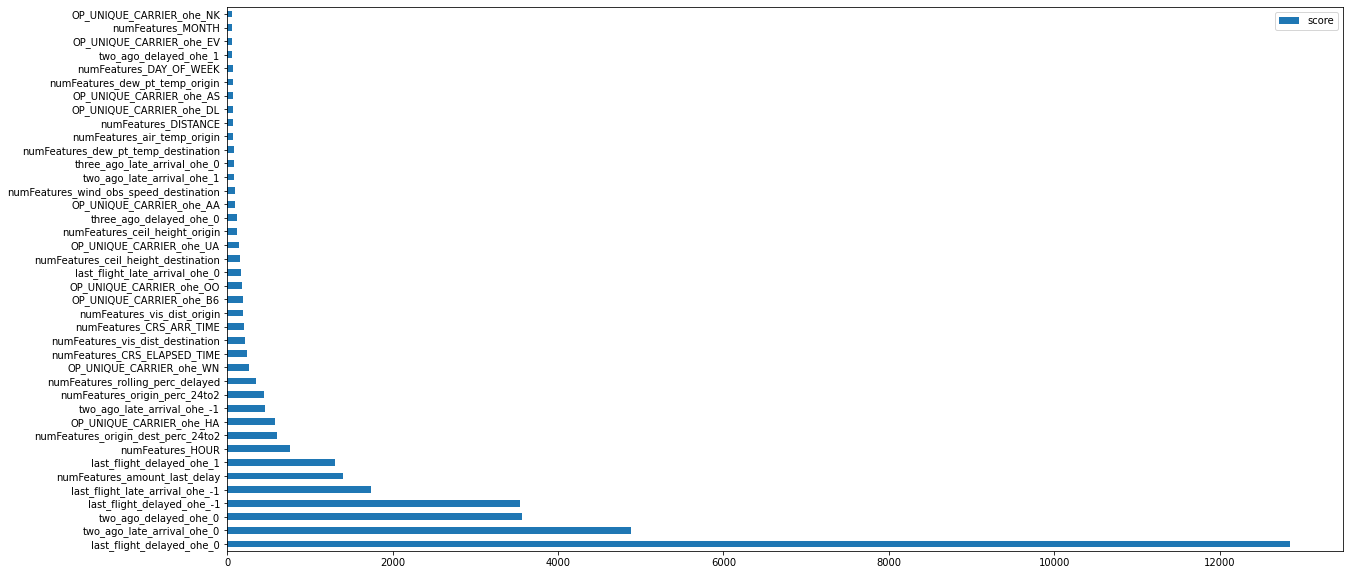

<AxesSubplot:>

In [0]:
# Get the feature importance after the OHE transformation
feature_important = xgb_mod.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
feature_indices = [int(i[1:]) for i in keys]
values = list(feature_important.values())
# Create a dictionary of the extracted feature indices and their importance scores
idx_scores = {feature_indices[i]:values[i] for i in range(len(feature_indices))}

# Create a dictionary to hold the list of feature names
extracted_feats = {}
# Extract the features
for x in test_preds.schema['features'].metadata['ml_attr']['attrs']['numeric']: extracted_feats[x['idx']] = x['name']
for x in test_preds.schema['features'].metadata['ml_attr']['attrs']['binary']: extracted_feats[x['idx']] = x['name']

# Create a new dictionary to hold the feature names and feature importance scores
feat_imp = {extracted_feats.get(k):v for k, v in idx_scores.items()}
import pandas as pd
data = pd.DataFrame(data=feat_imp.values(), index=feat_imp.keys(), columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

#### XGBoost Classifier with Time-Series Cross Validation and Hyperparameter Tuning

In [0]:
# set up grid search: estimator, set of params, and evaluator
xgb_cv = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0)
# Add parameters to test for learning rate, tree depth, and regularization penalties (L1 and L2)
grid = ParamGridBuilder()\
            .addGrid(xgb_cv.max_depth, [5,6,7,8,9,10])\
            .addGrid(xgb_cv.reg_lambda, [1e-3, 1e-2, 1e-1])\
            .addGrid(xgb_cv.reg_alpha, [1e-3, 1e-2, 1e-1])\
            .addGrid(xgb_cv.subsample, [0.7, 1])\
            .addGrid(xgb_cv.learning_rate, [0.001, 0.01, 0.1, 0.3])\
            .build()

evaluator = BinaryClassificationEvaluator()

# run cross validation
cv = CustomCrossValidator(estimator=xgb_cv, estimatorParamMaps=grid, evaluator=evaluator,
     splitWord = ('train', 'test'), cvCol = 'cv', parallelism=4)

# Fit the model to the training data
cvModel = cv.fit(d3)

fold 1 start...